# Problem Statement

Our problem itself is a segmentation problem, that is, classifying pixels. But in general, deep learning requires complete segmentation mask during training. And our annotation is based on points, or incomplete tagging, which is not a common deep learning situation, and it's a very challenging problem.

## 1. Preprocessing

Installing and importing essentials (Kaggle, PyTorch and dataset).

### 1.1 Installing and configuring Kaggle to download dataset

In [75]:
!pip install kaggle

In [76]:
# Creating Kaggle directory to host kaggle.json (API Key)
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"username","key":"api-key"} # anonymized key

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [77]:
# Downloading the DeepGlobe Road Extraction dataset from Kaggle
!kaggle datasets download -d balraj98/deepglobe-road-extraction-dataset

Dataset URL: https://www.kaggle.com/datasets/balraj98/deepglobe-road-extraction-dataset
License(s): other
deepglobe-road-extraction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [88]:
# Using zipfile to extract contents of deepglobe-road-extraction-dataset.zip
import zipfile
zip_ref = zipfile.ZipFile('/content/deepglobe-road-extraction-dataset.zip', 'r')
zip_ref.extractall('dataset')
zip_ref.close()

### 1.2 Importing PyTorch

In [89]:
# Importing PyTorch and nn (Module)
import torch
import torch.nn as nn

### 1.3 Writing device agnostic code

In [90]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## 2. Creating Partial Cross Entropy Loss function


### 2.1 Partial Cross Entropy Loss

In [292]:
# Creating a Partial Cross Entropy Loss class
class PartialCrossEntropyLoss(nn.Module):
  def __init__(self):
    super(PartialCrossEntropyLoss, self).__init__() # initializing constructor
    self.loss_fn = nn.CrossEntropyLoss(reduction='none') # using CrossEntropyLoss as loss function,
                                                      # reduction='none' means the loss will be returned for each individual element instead of being averaged, allowing us to calculate loss only on the labeled points

  def forward(self, outs, targets, mask): # overriding base forward pass, the params represent out=output predictions, targets=true labels of the data, mask=binary mask indicating which pixels are labeled
    targets = targets.view(targets.size(0), -1)
    mask = mask.view(mask.size(0), -1)
    outs = outs.view(outs.size(0), outs.size(1), -1)

    loss = self.loss_fn(outs, targets) # calculating standard cross entropy loss between preds and labels for each element
    mask_loss = loss * mask # applying mask to unlabeled pixels
    num_labeled = torch.sum(mask) # counting the number of labeled pixels through summation
    if num_labeled == 0: # if no labeled pixels found
      return torch.tensor(0.0, requires_grad=True) #returns 0 loss over labeled pixels
    return torch.sum(mask_loss) / num_labeled

### 2.2 Creating some sample input for testing

In [293]:
# Writing testing code
batch_size = 2
num_classes = 5
height, width = 10, 10

# Generating random values for preds, labels (outputs, targets) and mask based on manual_seed
outputs = torch.randn(batch_size, num_classes, height, width, requires_grad=True)
targets = torch.randint(0, num_classes, (batch_size, height, width))
mask = torch.randint(0, 2, (batch_size, height, width)).type(torch.float32)

# Setting data to 'cuda' device if available
outputs = outputs.to(device)
targets = targets.to(device)
mask = mask.to(device)

# Calculating loss
loss_fn = PartialCrossEntropyLoss()
loss = loss_fn(outputs, targets, mask)
loss.backward()

print(f"Computed loss: {loss.item()}")

Computed loss: 1.9719582796096802


### 2.3 Importing Pandas, Numpy and DataLoader (among others) for dataset model

In [294]:
import pandas as pd
import numpy as np
import torch
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

### 2.4 Creating model for Road Extraction dataset

In [295]:
class RoadExtractionDataset(Dataset): # inheriting from PyTorch's Dataset module (imported in above cell)
  def __init__(self, data_dir, transform=None, mask_transform=None): # initializing class, data_dir=location of images from dataset, transform = optional transform params, mask_transform = optional transform params for mask
    self.data_dir = data_dir
    self.transform = transform
    self.mask_transform = mask_transform
    self.img_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')] # gets all images by '.jpg' extension

  def __len__(self): # overriden Dataset __len__ function to fetch number of images
    return len(self.img_files)

  def __getitem__(self, idx): # overriden Dataset __getitem__ function to access data samples and fetch an image
    img_file = self.img_files[idx]
    mask_file = img_file.replace('_sat.jpg', '_mask.png')

    img = Image.open(os.path.join(self.data_dir, img_file)).convert("RGB")
    mask = Image.open(os.path.join(self.data_dir, mask_file)).convert("RGB")

    if self.transform:
      img = self.transform(img)
    if self.mask_transform:
      mask = self.mask_transform(mask)

    mask = transforms.ToTensor()(mask) # converting mask to a tensor

    return img, mask

  def rgb_to_class_indices(self, mask): # RGB -> class indices mapper where class indices correspond to pixels in the mask
    rgb_to_class = {
        (255, 255, 255): 0, (0, 0, 0): 1
    }
    class_indices = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8) # storing class indices using NumPy zero-initialized array, mask[0] & mask[1] correspond to height & width shape values
    for rgb, class_idx in rgb_to_class.items():
      class_indices[np.all(mask == rgb, axis=-1)] = class_idx # compares each pixel's RGB value to values in rgb_to_class array. True and False values are stored in the resulting array depending on comparison
    return class_indices

### 2.5 Creating data splits and dataloader

In [296]:
# Setting inputs for the dataset model and preparing for training and testing
data_dir = '/content/dataset/train' # directory location of dataset images
transform = transforms.Compose([ # chaining transformations
    transforms.Resize((128, 128)), # resizing img to standard 128x128
    transforms.ToTensor() # converting img to a PyTorch tensor (to be used in a PyTorch model)
]) #
mask_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=Image.NEAREST) # interpolation=NEAREST ensures that the mask is resized using nearest-neighbor interpolation to preserve the distinct pixel values representing different classes
])
dataset = RoadExtractionDataset(data_dir, transform, mask_transform)
train_size = int(0.8 * len(dataset)) # Setting training data ratio to 80%
test_size = len(dataset) - train_size # calculates to 20% as per train_size value above

# Creating data_loader
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True) # shuffling to avoid learning ordering
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False) # shuffling not required during eval stage

### 2.6 Visualization of the Training Model

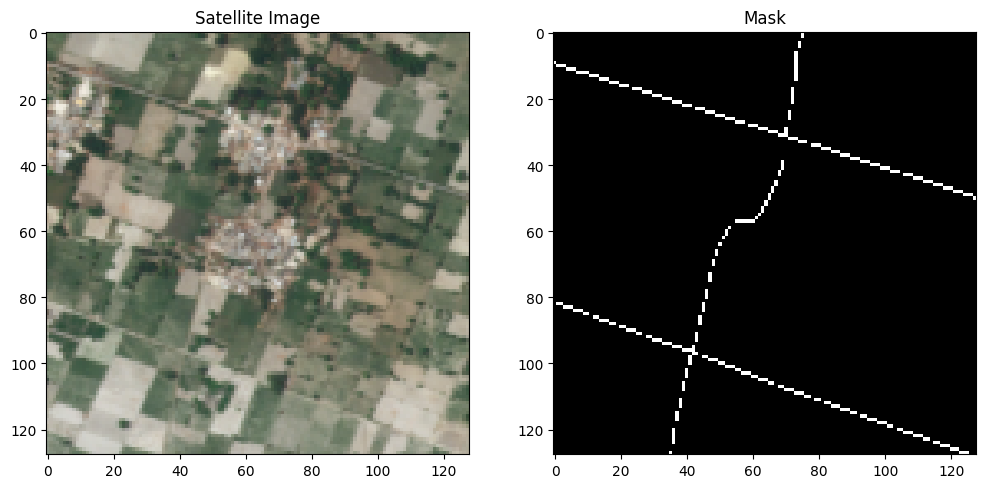

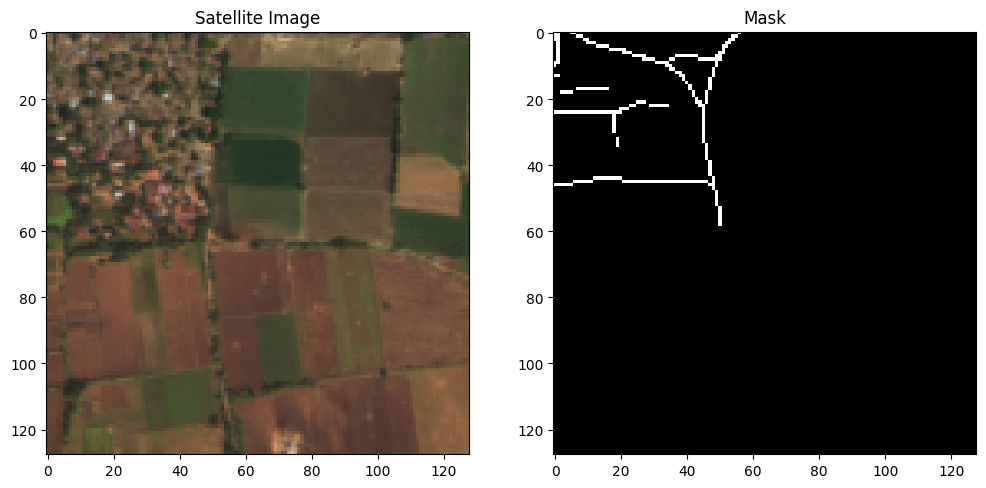

In [297]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def visualize_samples(train_dataloader, num_samples=4):
    samples = iter(train_dataloader) # Creates an iterator (samples) from the train_dataloader to access data batches sequentially
    for _ in range(num_samples):
        images, masks = next(samples) # Retrieves the next batch of images and masks from the samples iterator
        for i in range(images.size(0)):
            image = TF.to_pil_image(images[i]) # Converts the current image tensor to a PIL Image object
            mask = masks[i].permute(1, 2, 0).numpy() # Process the mask tensor, rearranging its dimensions and then conveerting it to a NumPy array
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title("Satellite Image")
            plt.subplot(1, 2, 2)
            plt.imshow(mask, cmap='gist_earth_r')
            plt.title("Mask")
            plt.show()

visualize_samples(train_dataloader, num_samples=1)

## 3. Testing and labeling (evaluation)

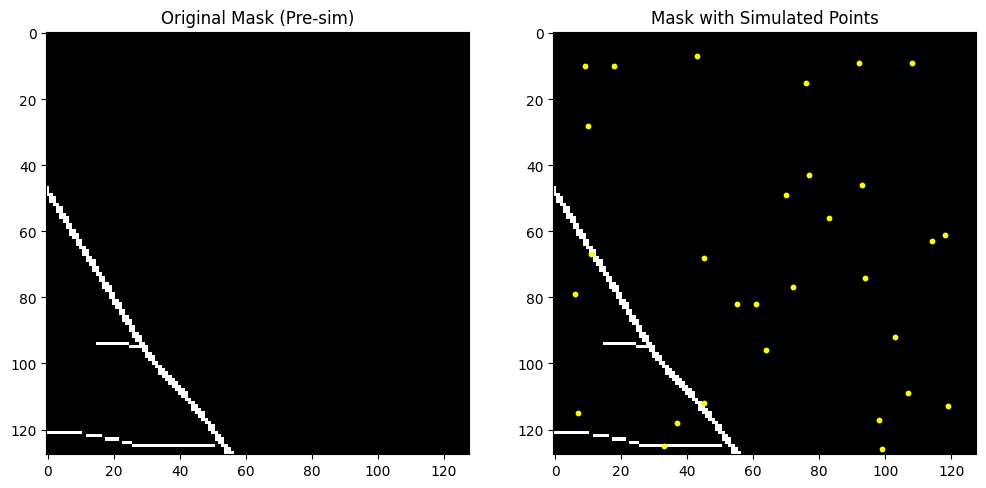

In [298]:
def simulate_point_labels(mask, num_points=30): # Simulation of Label Points
    point_mask = torch.zeros_like(mask)
    height, width = mask.shape[-2], mask.shape[-1]
    points = []
    for _ in range(num_points):
      x = torch.randint(0, height, (1,)).item() # Generates a random x-coordinate within the mask's height
      y = torch.randint(0, width, (1,)).item() # Generates a random y-coordinate within the mask's width
      point_mask[..., x, y] = mask[..., x, y] # Copies the value from the original mask at the randomly chosen (x, y) location to the point_mask. This simulates labeling that specific point
      points.append((x, y))
    return point_mask, points

import numpy as np

# Generating simulated point labels and their coordinates
for images, masks in train_dataloader:
    simulated_point_labels, points = simulate_point_labels(masks[0])
    break

# Converting mask and simulated points to NumPy arrays
mask_np = masks[0].numpy()
simulated_points_np = simulated_point_labels.numpy()

# Visualization using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Original mask image
plt.subplot(1, 2, 1)
plt.imshow(mask_np.transpose(1, 2, 0), cmap='gist_earth_r') # Transposing the dimensions of mask_np to (128, 128, 3)
plt.title("Original Mask (Pre-sim)")

# Labeled mask image
plt.subplot(1, 2, 2)
plt.imshow(mask_np.transpose(1, 2, 0), cmap='gist_earth_r') # Transposing the dimensions of mask_np to (128, 128, 3)
for point in points:
    plt.scatter(point[1], point[0], color='yellow', s=10)  # y is x coordinate, x is y coordinate
plt.title("Mask with Simulated Points")

plt.show()

## 3.1 Building an NN model to train

In [311]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleNNModel(nn.Module): # Simple Neural Network with ReLU nonlinearity over linear layers
    def __init__(self, input_features, output_features, hidden_units=8): # NN takes input and output features as well as a param for hidden units for training
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=2 * 128 * 128), # Using total pixel value for output
            nn.Unflatten(1, (2, 128, 128))
        )

    def forward(self, x):
      return self.layer_stack(x)

model = SimpleNNModel( # NN params
    input_features = 3 * 128 * 128,
    output_features = 2,
    hidden_units = 8
).to(device)  # Move model to GPU if available
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = PartialCrossEntropyLoss()

num_epochs = 5 # Number of iterations to be performed over dataset
for epoch in range(num_epochs):
    model.train()
    for images, masks in train_dataloader:
      images, masks = images.to(device), masks.to(device)
      point_labels, _ = simulate_point_labels(masks)
      masks = masks[:, 0, :, :].long()
      point_labels = point_labels[:, 0, :, :].long()

      # Forward pass
      outputs = model(images)

      # Calculate the loss
      loss = loss_fn(outputs, masks, point_labels)

      # Optimizer zero grad
      optimizer.zero_grad()

      # Loss backward (backpropagation)
      loss.backward()

      # Optimizer step (gradient descent)
      optimizer.step()

    print(f"Epoch: {epoch+1} \nLoss: {loss.item()}")

Epoch: 1 
Loss: 0.734638512134552
Epoch: 2 
Loss: 0.8650660514831543
Epoch: 3 
Loss: 0.6613938212394714
Epoch: 4 
Loss: 0.0
Epoch: 5 
Loss: 0.591564416885376
---End---


## 3.3 Evaluating our trained model on testing data

In [317]:
def partial_cross_entropy_loss_eval(predictions, targets, mask_labeled):
    predictions = predictions.to(device)
    targets = targets.to(device)
    mask_labeled = mask_labeled.to(device)
    # mask_labeled has shape (batch, channel, height, width)
    # Squeezing the channel dimension to get (batch, height, width)
    mask_labeled = mask_labeled[:, 0, :, :]  # Selecting the first channel

    loss_fn = nn.CrossEntropyLoss(reduction='none')

    # targets also has shape (batch, channel, height, width)
    # Squeezing the channel dimension to get (batch, height, width)
    targets = targets[:, 0, :, :].long()  # Selecting the first channel and converting to long

    crossloss = loss_fn(predictions, targets)
    masked_loss = crossloss * mask_labeled
    total_labeled_points = mask_labeled.sum()
    pce = masked_loss.sum() / total_labeled_points
    return pce

def evaluate_model(model, dataloader, loss_fn): # Evaluate Model
    model.eval()
    total_loss = 0
    with torch.inference_mode(): # Initiating inference_mode for evaluation
      for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        point_labels, _ = simulate_point_labels(masks)
        outputs = model(images)
        loss = loss_fn(outputs, masks, point_labels)
        if torch.isnan(loss): # Skipping possible NaN values for stability
          continue
        total_loss += loss.item()
    return total_loss / len(dataloader)

test_loss = evaluate_model(model, test_dataloader, partial_cross_entropy_loss_eval) # Calculating total test loss value when divided by number of items

print(f'Test Loss: {test_loss}')

Test Loss: 0.5346381113196261


# 4. Experimentation

## 4.1 Hypothesis 1

Using a more powerful neural network, such as a Deep UNet network, would significantly improve the accuracy of our model.

In [320]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DeepUNet(nn.Module): # Implementation of Deep UNet network for superior results
    def __init__(self, in_channels=3, out_channels=2, depth=1):
        super(DeepUNet, self).__init__()
        self.depth = depth
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        # Encoder
        channels = in_channels
        for i in range(depth):
            self.encoder.append(self._make_encoder_layer(channels, 64 * (2**i)))
            channels = 64 * (2**i)

        # Decoder
        for i in range(depth - 1, -1, -1):
            self.decoder.append(self._make_decoder_layer(64 * (2**i), 64 * (2**max(i-1, 0))))

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()

    def _make_encoder_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

    def _make_decoder_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        # Encoder
        encoder_outputs = []
        for encoder_layer in self.encoder:
            x = encoder_layer(x)
            encoder_outputs.append(x)

        # Decoder
        for i, decoder_layer in enumerate(self.decoder):
            x = decoder_layer(x)
            if i < len(self.decoder) - 1:
                x = torch.cat([x, encoder_outputs[-i-2]], dim=1)

        x = self.final_conv(x)
        x = self.sigmoid(x)
        return x

# Function to train and evaluate the model
def train_and_evaluate(model, train_dataloader, test_dataloader, num_epochs=2):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = PartialCrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, masks in train_dataloader:
            images, masks = images.to(device), masks.to(device)
            point_labels, _ = simulate_point_labels(masks)

            # Reshaping the target masks to [batch_size, height * width]
            masks = masks[:, 0, :, :].long() # Selecting the first channel and converting to long

            # Reshaping the target point_labels to [batch_size, height * width]
            point_labels = point_labels[:, 0, :, :].long() # Selecting the first channel and converting to long

            outputs = model(images)
            loss = loss_fn(outputs, masks, point_labels)

            # Optimizer zero grad
            optimizer.zero_grad()

            # Loss backward (backpropagation)
            loss.backward()

            # Optimizer step (gradient descent)
            optimizer.step()

            # Accumulating total loss
            total_loss += loss.item()

        print(f"Epoch: {epoch+1}, Train Loss: {total_loss/len(train_dataloader)}")

    test_loss = evaluate_model(model, test_dataloader, partial_cross_entropy_loss_eval)
    return test_loss

# Experiment with different depths
depths = [1, 2, 3, 4]
results = []

for depth in depths:
    print(f"Training model with depth {depth}")
    model = DeepUNet(depth=depth).to(device)
    test_loss = train_and_evaluate(model, train_dataloader, test_dataloader)
    results.append((depth, test_loss))
    print(f"Depth: {depth}, Test Loss: {test_loss}\n")

# Print final results
print("Final Results:")
for depth, loss in results:
    print(f"Depth: {depth}, Test Loss: {loss}")

Training model with depth 1
Epoch: 1, Train Loss: 0.25546133404515353
Epoch: 2, Train Loss: 0.2557674504307858
Depth: 1, Test Loss: 0.2483968847636044

Training model with depth 2


RuntimeError: Given transposed=1, weight of size [64, 64, 2, 2], expected input[2, 128, 64, 64] to have 64 channels, but got 128 channels instead